In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Step 1: Load the data
(ds_train, ds_test), ds_info = tfds.load(
    'beans',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1034 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/beans/incomplete.DMY8KI_0.1.0/beans-train.tfrecord*...:   0%|          | 0…

Generating validation examples...:   0%|          | 0/133 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/beans/incomplete.DMY8KI_0.1.0/beans-validation.tfrecord*...:   0%|        …

Generating test examples...:   0%|          | 0/128 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/beans/incomplete.DMY8KI_0.1.0/beans-test.tfrecord*...:   0%|          | 0/…

Dataset beans downloaded and prepared to /root/tensorflow_datasets/beans/0.1.0. Subsequent calls will reuse this data.


In [ ]:
# Step 2: Preprocess the data
IMG_SIZE = 224  # MobileNet standard input size
BATCH_SIZE = 32

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1] range
    return image, label

ds_train = ds_train.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

<Figure size 1000x1000 with 0 Axes>

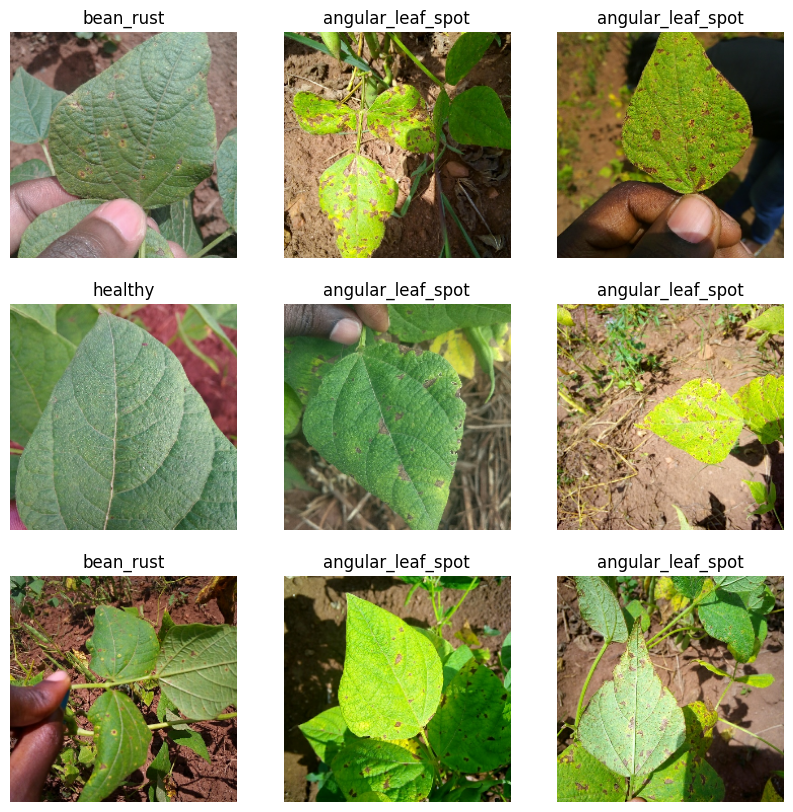

In [ ]:

# Step 3: Visualize the data
class_names = ds_info.features['label'].names
plt.figure(figsize=(10, 10))
# Unbatch the dataset for visualization and shuffle it
ds_train_unbatched = ds_train.unbatch().shuffle(buffer_size=1000)

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(ds_train_unbatched.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy())
    plt.title(class_names[label.numpy()])
    plt.axis("off")
plt.show()

In [ ]:

# Step 4: Load MobileNet for Transfer Learning
base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

# Add new classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(len(class_names), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Step 5: Apply Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 291ms/step - accuracy: 0.6620 - loss: 0.7951 - val_accuracy: 0.8750 - val_loss: 0.3236
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.9239 - loss: 0.2212 - val_accuracy: 0.8906 - val_loss: 0.2727
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9334 - loss: 0.1614 - val_accuracy: 0.9297 - val_loss: 0.2312
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9510 - loss: 0.1339 - val_accuracy: 0.8906 - val_loss: 0.2653
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9747 - loss: 0.0924 - val_accuracy: 0.8516 - val_loss: 0.4018
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9639 - loss: 0.0947 - val_accuracy: 0.9219 - val_loss: 0.1970
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9955 - loss: 0.0357 - val_accuracy: 0.9297 - val_loss: 0.1970
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 1.0000 - loss: 0.0262 - val_accuracy: 0.9141 -

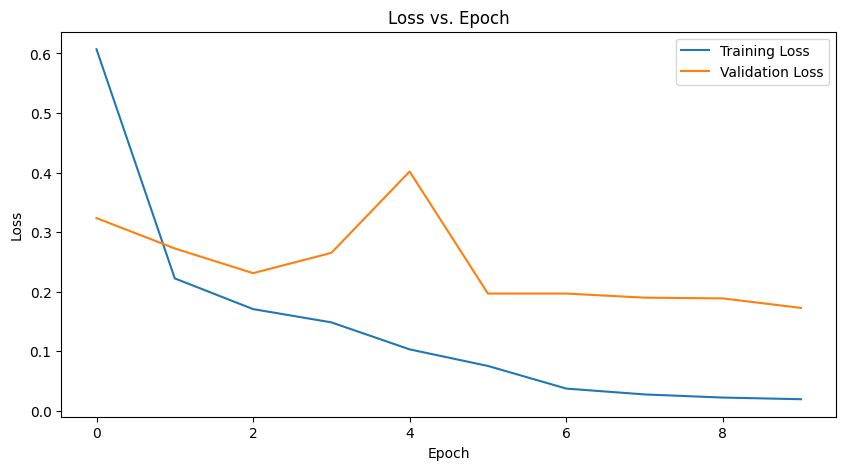

In [ ]:
# Step 6: Train the Model
history = model.fit(ds_train, epochs=10, validation_data=ds_test, callbacks=[early_stopping])

# Step 7: Plot Loss vs. Epoch
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


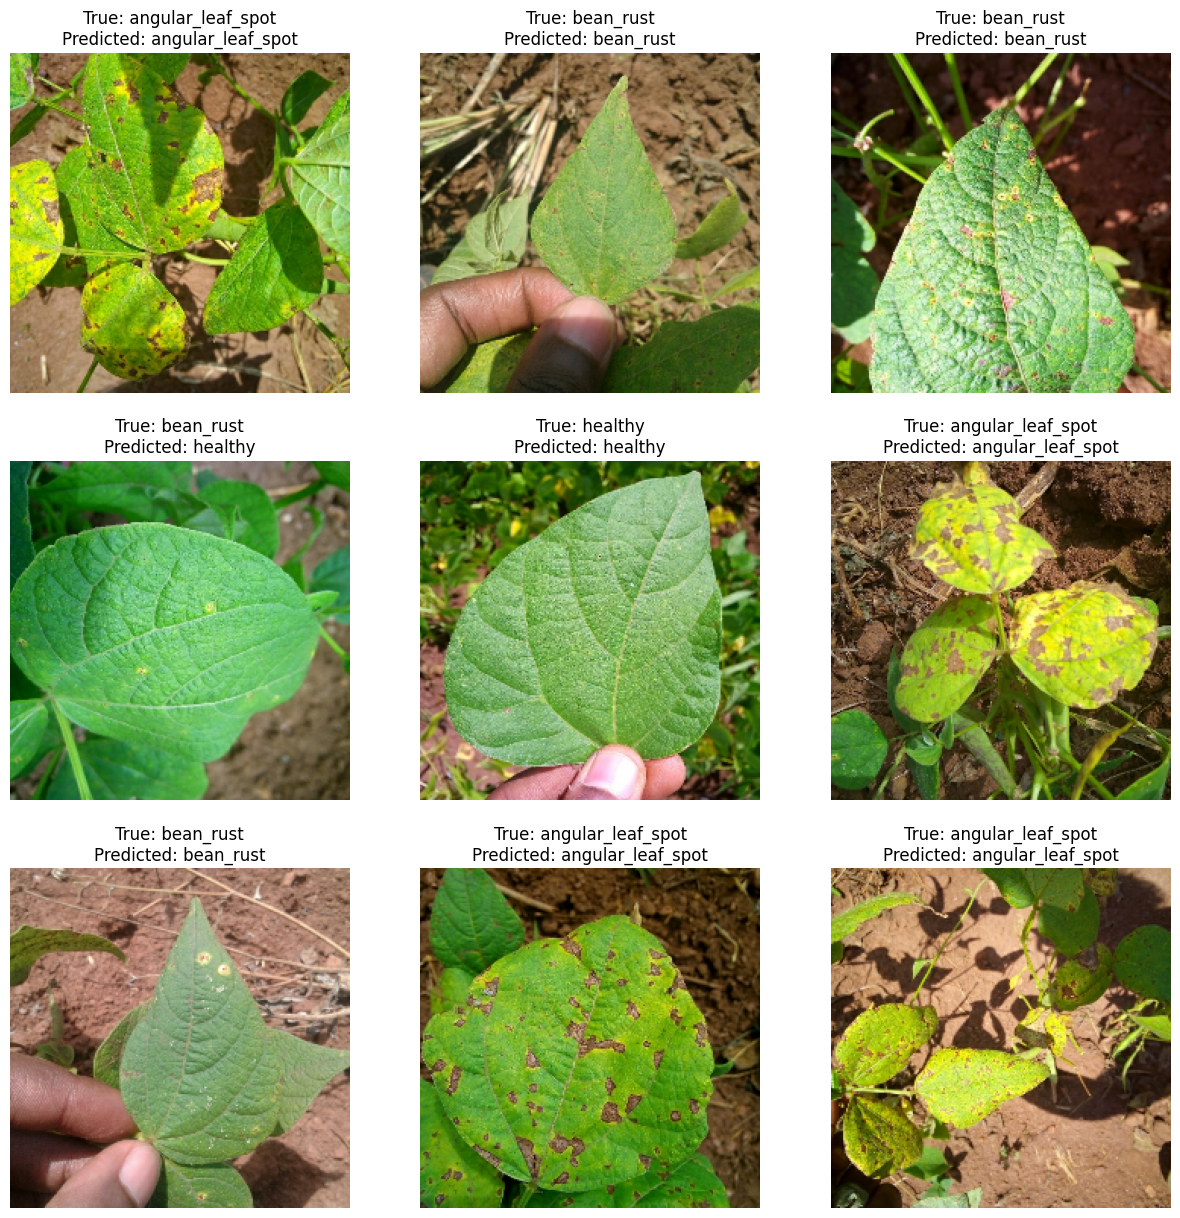

In [ ]:

# Step 8: Predict on the Test Data
test_images, test_labels = next(iter(ds_test))
predictions = model.predict(test_images)

# Step 9: Visualize the Results on Test Samples
plt.figure(figsize=(15, 15))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(test_images[i].numpy())
    predicted_label = class_names[tf.argmax(predictions[i])]
    true_label = class_names[test_labels[i].numpy()]
    plt.title(f'True: {true_label}\nPredicted: {predicted_label}')
    plt.axis("off")
plt.show()

In [ ]:
# model.evaluate(test_images)

In [ ]:
model.save('/content/drive/MyDrive/SRM_DeepLearning/mobilenetv2_beans_model.h5')

In [ ]:
model.save('/content/drive/MyDrive/SRM_DeepLearning/mobilenetv2_beans_model.keras')